In [2]:
import os
from pathlib import Path
import glob
import shutil
import scipy

## Folders

In [3]:
#!rm -rf /home/jovyan/workspace/Fish/train

#!rm -rf /home/jovyan/workspace/Fish/validation


In [4]:
folders = "/home/jovyan/workspace/Fish/"
folder_list= os.listdir("/home/jovyan/workspace/Fish")

In [5]:
print(folder_list)
len(folder_list)

['Gilt-Head Bream', 'Striped Red Mullet', 'Red Mullet', 'Shrimp', 'Black Sea Sprat', 'Trout', 'Red Sea Bream', 'Sea Bass', 'Hourse Mackerel']


9

In [13]:
for folder in folder_list:
    print(len(os.listdir(f"Fish/{folder}")))


1000
1000
1000
1000
1000
1000
1000
1000
1000


In [14]:
TRAIN_DIR = f"{folders}train"
VAL_DIR = f"{folders}validation"

In [15]:
train_dir = os.path.join(folders, "train")
os.makedirs(train_dir, exist_ok=True)
val_dir = os.path.join(folders, "validation")
os.makedirs(val_dir, exist_ok=True)

In [16]:
for folder in folder_list:
    folder = os.path.join(TRAIN_DIR, folder)
    os.makedirs(folder, exist_ok=True)

for folder in folder_list:
    folder = os.path.join(VAL_DIR, folder)
    os.makedirs(folder, exist_ok=True)

In [17]:
import matplotlib.pyplot as plt
import PIL


In [18]:
for folder in folder_list:
    pngs = [f for f in os.listdir(folders+folder) if '.png' in f.lower()]
    i = 1
    dest_path= TRAIN_DIR
    for png in pngs:
        source = f"{folders}{folder}/{png}"
        #print(source)
        dest = f"{dest_path}/{folder}/{png}"
        #print(dest)
        if i == 700:
            dest_path = VAL_DIR
        shutil.move(source, dest)
        i+=1

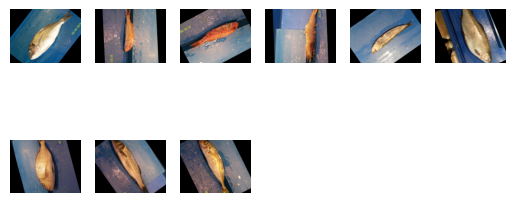

In [19]:
files=[]
rows = 3
for folder in folder_list:
    img = os.path.join(f"{TRAIN_DIR}/{folder}/00001.png")
    files.append(img)

for num, x in enumerate(files):
    img = PIL.Image.open(x)
    plt.subplot(rows,6,num+1)
    plt.axis('off')
    plt.imshow(img)

### Model MobileNetV2

In [20]:
from tensorflow.keras import backend as c
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2023-10-26 19:57:08.334766: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [21]:
training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen  = ImageDataGenerator(preprocessing_function= preprocess_input)

In [45]:
train_ds = training_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=True
)

val_ds = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=True
)


Found 6300 images belonging to 9 classes.
Found 2700 images belonging to 9 classes.


In [66]:
import mlflow
mlflow.tensorflow.autolog()

#### Model Function

In [24]:
def make_model(hp):
    base_model = MobileNetV3Large(
        include_top=False, 
        weights="imagenet", 
        pooling='avg', 
        input_shape=(224, 224, 3))
    base_model.trainable = False

    base_model.trainable = False
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))

    
    x = base_model(inputs)

    size_inner= hp.Choice("size_inner", values = [64, 128, 256])

    x = tf.keras.layers.Dense(size_inner, activation="relu")(x)


    outputs =  tf.keras.layers.Dense(9, activation='softmax')(x)


    model = tf.keras.models.Model(inputs, outputs)

    learning_rate = hp.Choice("learning_rate", values=[0.001, 0.005])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
    

In [ ]:
train_ds = training_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=True
)

val_ds = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=True
)


Found 6300 images belonging to 9 classes.
Found 2700 images belonging to 9 classes.



Tensorboard Callback


In [25]:
log_dir="/home/jovyan/workspace/logs/fit"
callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=0,
write_graph=True,
write_images=False,
write_steps_per_second=False,
update_freq='epoch',
profile_batch=0,
embeddings_freq=0,
embeddings_metadata=None,)

In [26]:
import keras_tuner
from keras_tuner.tuners import RandomSearch


Using TensorFlow backend


In [27]:
import scipy

In [28]:
tuner = RandomSearch(
    make_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="dir") 

tuner.search_space_summary()

2023-10-26 19:57:24.484339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-26 19:57:24.491112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-26 19:57:24.491362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-26 19:57:24.491872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Search space summary
Default search space size: 2
size_inner (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.005], 'ordered': True}


In [29]:
tuner.search(train_ds, epochs=20, validation_data=val_ds, callbacks=[callback])

Trial 6 Complete [00h 25m 25s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 02h 33m 23s


### Best Model

In [31]:
best_params = tuner.get_best_hyperparameters(1)[0]
print(best_params.values)

{'size_inner': 128, 'learning_rate': 0.001}


In [32]:
best_model_mobilenet = tuner.hypermodel.build(best_params)

In [36]:
path_checkpoint = f"/home/jovyan/workspace/model_checkpoint_mobilenet.h5"
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
monitor="val_loss",
filepath=path_checkpoint,
verbose=1,
save_weights_only=False,
save_best_only=True)

In [37]:
history_mobilenet = best_model_mobilenet.fit(train_ds, epochs=20, validation_data=val_ds,
                   callbacks=[callback, modelckpt_callback])

2023/10/26 22:42:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '37bbd3eeed0d4e8db6640c8f092b214c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/10/26 22:42:25 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2023/10/26 22:42:25 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.00320, saving model to /home/jovyan/workspace/model_checkpoint_mobilenet.h5
50/50 [==============================] - 74s 1s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.00320 to 0.00247, saving model to /home/jovyan/workspace/model_checkpoint_mobilenet.h5
50/50 [==============================] - 74s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.00247 to 0.00195, saving model to /home/jovyan/workspace/model_checkpoint_mobilenet.h5
50/50 [==============================] - 74s 1s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.

2023/10/26 23:07:19 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/10/26 23:07:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpyjmq08y6/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpyjmq08y6/model/data/model/assets


### Test Dataset

In [39]:
TEST = "/home/jovyan/workspace/NA_Fish_Dataset"
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [41]:
test_ds = training_datagen.flow_from_directory(
    TEST,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=True
)

Found 431 images belonging to 9 classes.


In [42]:
best_model_mobilenet.evaluate(test_ds)

4/4 [==============================] - 20s 5s/step - loss: 0.1022 - accuracy: 0.9652


[0.10220431536436081, 0.9651972055435181]

### Model Resnet

In [52]:
from tensorflow.keras import backend as c
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [53]:
training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen  = ImageDataGenerator(preprocessing_function= preprocess_input)

In [54]:
train_ds = training_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=True
)

val_ds = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=True
)


Found 6300 images belonging to 9 classes.
Found 2700 images belonging to 9 classes.


In [59]:
def make_model_resnet(hp):
    base_model = ResNet50V2(
        include_top=False, 
        weights="imagenet", 
        pooling='avg', 
        input_shape=(224, 224, 3))
    base_model.trainable = False

    base_model.trainable = False
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))

    
    x = base_model(inputs)

    size_inner= hp.Choice("size_inner", values = [64, 128, 256])

    x = tf.keras.layers.Dense(size_inner, activation="relu")(x)


    outputs =  tf.keras.layers.Dense(9, activation='softmax')(x)


    model = tf.keras.models.Model(inputs, outputs)

    learning_rate = hp.Choice("learning_rate", values=[0.001, 0.005])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
    

In [56]:
log_dir="/home/jovyan/workspace/logs/fit"
callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=0,
write_graph=True,
write_images=False,
write_steps_per_second=False,
update_freq='epoch',
profile_batch=0,
embeddings_freq=0,
embeddings_metadata=None,)

In [67]:
tuner = RandomSearch(
    make_model_resnet,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="dir2") 

tuner.search_space_summary()

Search space summary
Default search space size: 2
size_inner (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.005], 'ordered': True}


In [68]:
tuner.search(train_ds, epochs=20, validation_data=val_ds, callbacks=[callback])

Trial 6 Complete [00h 25m 00s]
val_accuracy: 0.8700000047683716

Best val_accuracy So Far: 0.8799999952316284
Total elapsed time: 02h 33m 50s


### Best Model

In [69]:
best_params = tuner.get_best_hyperparameters(1)[0]
print(best_params.values)

{'size_inner': 256, 'learning_rate': 0.001}


In [70]:
best_model_resnet = tuner.hypermodel.build(best_params)

In [71]:
path_checkpoint = f"/home/jovyan/workspace/model_checkpoint_resnet.h5"
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
monitor="val_loss",
filepath=path_checkpoint,
verbose=1,
save_weights_only=False,
save_best_only=True)

In [72]:
history_resnet = best_model_resnet.fit(train_ds, epochs=20, validation_data=val_ds,
                   callbacks=[callback, modelckpt_callback])

2023/10/27 02:14:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b4ded6af79de4b37b6a0846652ce669f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/10/27 02:14:13 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2023/10/27 02:14:13 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 35.8345 - accuracy: 0.2483
Epoch 1: val_loss improved from inf to 5.75490, saving model to /home/jovyan/workspace/model_checkpoint_resnet.h5
50/50 [==============================] - 78s 2s/step - loss: 35.8345 - accuracy: 0.2483 - val_loss: 5.7549 - val_accuracy: 0.4241
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 4.2266 - accuracy: 0.4637
Epoch 2: val_loss improved from 5.75490 to 3.07035, saving model to /home/jovyan/workspace/model_checkpoint_resnet.h5
50/50 [==============================] - 74s 1s/step - loss: 4.2266 - accuracy: 0.4637 - val_loss: 3.0703 - val_accuracy: 0.5307
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 2.7106 - accuracy: 0.5619
Epoch 3: val_loss improved from 3.07035 to 2.49803, saving model to /home/jovyan/workspace/model_checkpoint_resnet.h5
50/50 [==============================] - 73s 1s/step - loss: 2.7106 - accuracy: 0.5619 - val_loss: 2.4980 - 

2023/10/27 02:38:42 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/10/27 02:38:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpugeatqfl/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpugeatqfl/model/data/model/assets
2023/10/27 02:39:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpugeatqfl/model, flavor: tensorflow), fall back to return ['tensorflow==2.9.1']. Set logging level to DEBUG to see the full traceback.


### Test Dataset

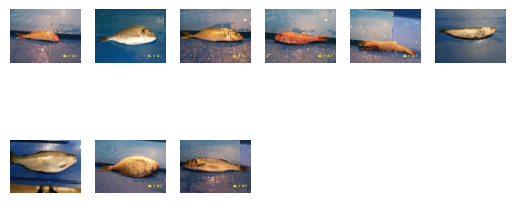

In [ ]:
folders = "/home/jovyan/workspace/Fish/NA_Fish_Dataset"
folder_list= os.listdir("/home/jovyan/workspace/NA_Fish_Dataset")
files=[]
rows = 3
for folder in folder_list:
    img = os.path.join(f"./NA_Fish_Dataset/{folder}/00001.png")
    files.append(img)

for num, x in enumerate(files):
    img = PIL.Image.open(x)
    plt.subplot(rows,6,num+1)
    plt.axis('off')
    plt.imshow(img)

In [78]:
TEST = "/home/jovyan/workspace/NA_Fish_Dataset"
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [79]:
test_ds = training_datagen.flow_from_directory(
    TEST,
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=True
)

Found 431 images belonging to 9 classes.


In [80]:
best_model_resnet.evaluate(test_ds)

4/4 [==============================] - 20s 5s/step - loss: 4.9175 - accuracy: 0.4849


[4.917471885681152, 0.4849188029766083]

### Upload to Huggingface

In [81]:
from huggingface_hub import push_to_hub_keras
from huggingface_hub import login
login()

In [82]:
push_to_hub_keras(best_model_mobilenet,
  "yusyel/fishv2",
  include_optimizer = True,
  tags = ["fish"],
log_dir = "/home/jovyan/workspace/logs/fit",

)

2023-10-27 02:42:23.069384: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_59 in the registry.
Traceback (most recent call last):

  File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_59 in the registry.


2023-10-27 02:42:23.069480: W tensorflow/core/kernels/data/generator_dataset_op.cc:108] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_59 in the registry.
Traceback (most recent call last):

  File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_59 

INFO:tensorflow:Assets written to: /tmp/tmpkneppnwo/yusyel/fishv2/assets


INFO:tensorflow:Assets written to: /tmp/tmpkneppnwo/yusyel/fishv2/assets


events.out.tfevents.1698362426.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.26.v2:   0…

keras_metadata.pb:   0%|          | 0.00/738k [00:00<?, ?B/s]

events.out.tfevents.1698362248.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.23.v2:   0…

Upload 51 LFS files:   0%|          | 0/51 [00:00<?, ?it/s]

events.out.tfevents.1698362512.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.28.v2:   0…

events.out.tfevents.1698350249.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.0.v2:   0%…

events.out.tfevents.1698362252.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.24.v2:   0…

events.out.tfevents.1698350253.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.1.v2:   0%…

events.out.tfevents.1698362430.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.27.v2:   0…

events.out.tfevents.1698362517.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.29.v2:   0…

events.out.tfevents.1698350313.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.2.v2:   0%…

events.out.tfevents.1698362311.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.25.v2:   0…

events.out.tfevents.1698362574.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.30.v2:   0…

events.out.tfevents.1698351817.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.3.v2:   0%…

events.out.tfevents.1698364061.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.31.v2:   0…

events.out.tfevents.1698351821.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.4.v2:   0%…

events.out.tfevents.1698364066.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.32.v2:   0…

events.out.tfevents.1698351877.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.5.v2:   0%…

events.out.tfevents.1698364122.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.33.v2:   0…

events.out.tfevents.1698353345.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.6.v2:   0%…

events.out.tfevents.1698365611.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.34.v2:   0…

events.out.tfevents.1698353350.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.7.v2:   0%…

events.out.tfevents.1698365616.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.35.v2:   0…

events.out.tfevents.1698353406.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.8.v2:   0%…

events.out.tfevents.1698365672.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.36.v2:   0…

events.out.tfevents.1698354876.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.9.v2:   0%…

events.out.tfevents.1698367158.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.37.v2:   0…

events.out.tfevents.1698354881.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.10.v2:   0…

events.out.tfevents.1698367163.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.38.v2:   0…

events.out.tfevents.1698354937.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.11.v2:   0…

events.out.tfevents.1698367219.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.39.v2:   0…

events.out.tfevents.1698356399.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.12.v2:   0…

events.out.tfevents.1698368698.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.40.v2:   0…

events.out.tfevents.1698356404.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.13.v2:   0…

events.out.tfevents.1698368703.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.41.v2:   0…

events.out.tfevents.1698356460.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.14.v2:   0…

events.out.tfevents.1698368759.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.42.v2:   0…

events.out.tfevents.1698357927.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.15.v2:   0…

events.out.tfevents.1698370242.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.43.v2:   0…

events.out.tfevents.1698357932.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.16.v2:   0…

events.out.tfevents.1698370247.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.44.v2:   0…

events.out.tfevents.1698357988.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.17.v2:   0…

events.out.tfevents.1698370301.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.45.v2:   0…

events.out.tfevents.1698359799.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.18.v2:   0…

events.out.tfevents.1698359827.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.19.v2:   0…

events.out.tfevents.1698360147.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.21.v2:   0…

events.out.tfevents.1698372854.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.46.v2:   0…

events.out.tfevents.1698359881.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.20.v2:   0…

events.out.tfevents.1698360199.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.22.v2:   0…

events.out.tfevents.1698372909.w-yusye-fish-93c488524fe84e469abfb4db4d275806-695b575d88-k9dzt.13381.47.v2:   0…

saved_model.pb:   0%|          | 0.00/4.09M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

'https://huggingface.co/yusyel/fishv2/tree/main/'